# The MovieLens Dataset

## Getting the Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [ ]:
# !unzip ml-latest-small.zip -d /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/AutoRec

In [3]:
def read_data_ml100k():
    data_dir = '/content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/AutoRec/ml-latest-small'
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'ratings.csv'), names = names, header=0)
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

## Statistics of the Dataset

In [4]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 610, number of items: 9724
matrix sparsity: 0.983000
   user_id  item_id  rating  timestamp
0        1        1     4.0  964982703
1        1        3     4.0  964981247
2        1        6     4.0  964982224
3        1       47     5.0  964983815
4        1       50     5.0  964982931


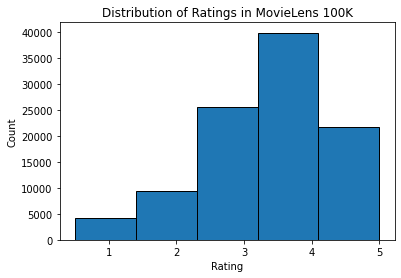

In [5]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

## Label Encoding

In [6]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user_id'].values)
data['item_id_idx'] = item_le.fit_transform(data['item_id'].values)

## Loading the data

In [7]:
class MovieLensDataset(Dataset):
    def __init__(self, df, train_size=0.9, train=False):
        self.df = df
        self.train = train
        self.train_size = train_size
        self.test_size = 1 - self.train_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())

        self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)

        if self.train == True:
            self.df = self.train_df
        else:
            self.df = self.test_df

        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_items, self.num_users))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[item][user] = rating

        return inter_mat

    def __len__(self):
        return len(self.inter_mat)

    def __getitem__(self, index):
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return inter_mat

# The AutoRec Model

In [8]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_users, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_users)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.sigmoid(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

## Training and Evaluating the Model

In [9]:
def trainer(model, train_iter, loss, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss_out = loss(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss_out.item()
    
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [10]:
def evaluator(model, test_iter, loss, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for inter_mat in test_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss_out = loss(preds, inter_mat)            

            loss_sum += loss_out.item()

    loss_avg = loss_sum / len(test_iter)

    return loss_avg

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.002
batch_size = 256

num_users = data.user_id_idx.max() + 1
num_hidden = 500

In [12]:
train_dataset = MovieLensDataset(df=data, train=True)
test_dataset = MovieLensDataset(df=data, train=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
model = AutoRec(num_hidden, num_users).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 0.1876, test Loss: 0.0229
epoch: 1, train Loss: 0.1378, test Loss: 0.0193
epoch: 2, train Loss: 0.1169, test Loss: 0.0164
epoch: 3, train Loss: 0.1008, test Loss: 0.0139
epoch: 4, train Loss: 0.0887, test Loss: 0.0123
epoch: 5, train Loss: 0.0798, test Loss: 0.0110
epoch: 6, train Loss: 0.0731, test Loss: 0.0100
epoch: 7, train Loss: 0.0679, test Loss: 0.0093
epoch: 8, train Loss: 0.0639, test Loss: 0.0084
epoch: 9, train Loss: 0.0603, test Loss: 0.0081
epoch: 10, train Loss: 0.0576, test Loss: 0.0079
epoch: 11, train Loss: 0.0553, test Loss: 0.0076
epoch: 12, train Loss: 0.0534, test Loss: 0.0072
epoch: 13, train Loss: 0.0515, test Loss: 0.0070
epoch: 14, train Loss: 0.0501, test Loss: 0.0068
epoch: 15, train Loss: 0.0486, test Loss: 0.0068
epoch: 16, train Loss: 0.0474, test Loss: 0.0067
epoch: 17, train Loss: 0.0461, test Loss: 0.0064
epoch: 18, train Loss: 0.0450, test Loss: 0.0064
epoch: 19, train Loss: 0.0440, test Loss: 0.0060
epoch: 20, train Loss: 0.0431,

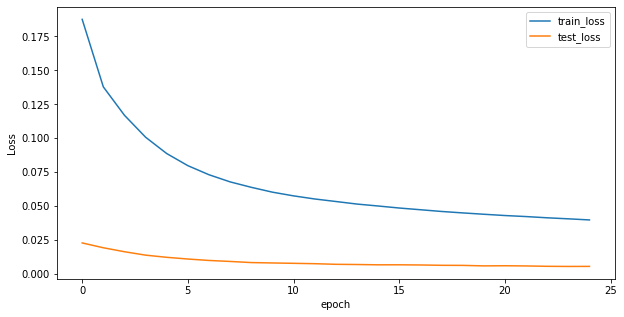

In [14]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):

    train_loss = trainer(model, train_dataloader, loss, optm, device)
    test_loss = evaluator(model, test_dataloader, loss, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(test_losses,label="test_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()